[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
4646/4646 [==============================] - 68s 14ms/step - loss: 1.5480e-04 - val_loss: 7.9669e-04
Epoch 2/10
4646/4646 [==============================] - 66s 14ms/step - loss: 9.6431e-05 - val_loss: 7.4973e-04
Epoch 3/10
4646/4646 [==============================] - 66s 14ms/step - loss: 8.4159e-05 - val_loss: 0.0038
Epoch 4/10
4646/4646 [==============================] - 66s 14ms/step - loss: 5.7413e-05 - val_loss: 0.0074
Epoch 5/10
4646/4646 [==============================] - 66s 14ms/step - loss: 5.6692e-05 - val_loss: 0.0104
Epoch 6/10
4646/4646 [==============================] - 65s 14ms/step - loss: 5.0962e-05 - val_loss: 0.0117
Epoch 7/10
1/1 [==============================] - 1s 825ms/step
5-day price forecast:
Day 1 (2023-05-01): 270.2070617675781
Day 2 (2023-05-02): 269.9893798828125
Day 3 (2023-05-03): 268.6520080566406
Day 4 (2023-05-04): 268.1554870605469
Day 5 (2023-05-05): 268.2581787109375

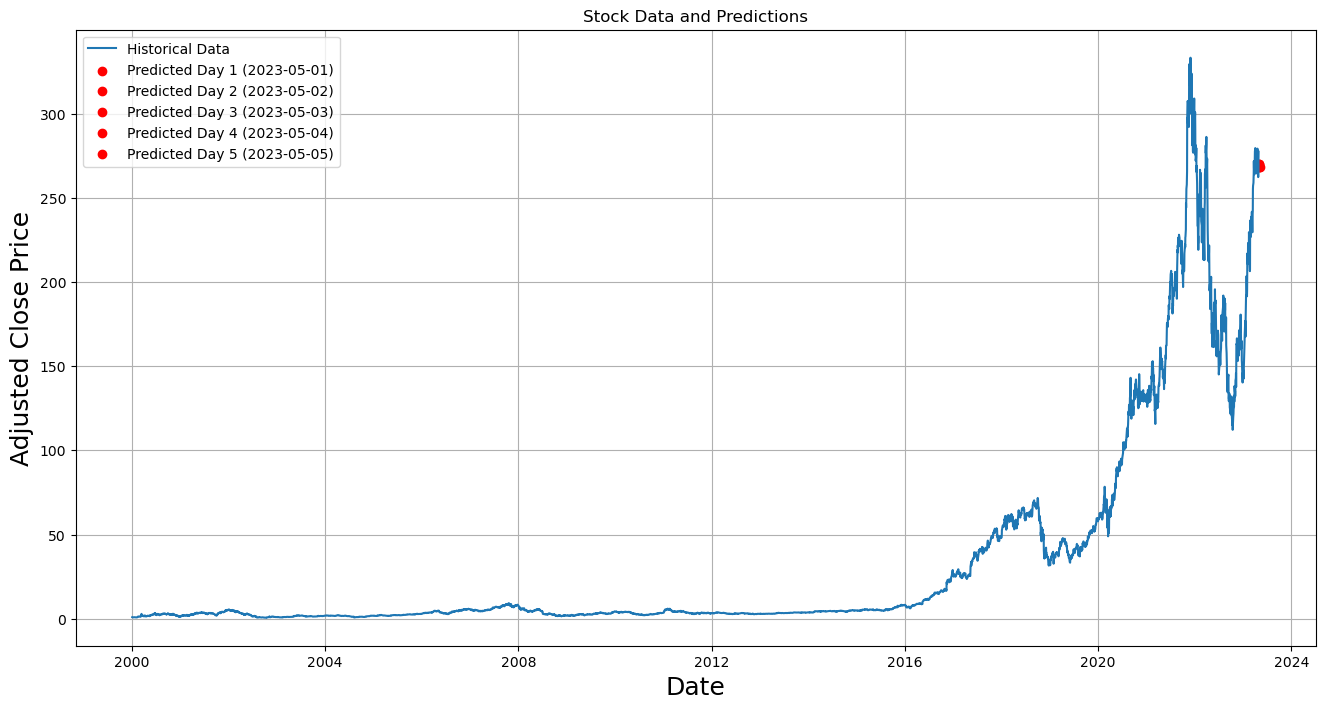

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import timedelta
import tensorflow as tf

def fetch_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

def prepare_data(stock_data, lookback):
    data = stock_data.filter(['Adj Close'])
    dataset = data.values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    x_data = []
    y_data = []

    for i in range(lookback, len(scaled_data)):
        x_data.append(scaled_data[i-lookback:i, 0])
        y_data.append(scaled_data[i, 0])

    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], 1))

    return x_data, y_data, scaler

def build_lstm_model(lookback):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


def plot_stock_data(stock_data, predictions, lookback, prediction_dates):
    plt.figure(figsize=(16, 8))
    plt.title('Stock Data and Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adjusted Close Price', fontsize=18)
    plt.plot(stock_data['Adj Close'])

    for i, prediction_date in enumerate(prediction_dates):
        plt.scatter(prediction_date, predictions[i], color='red', label=f'Predicted Day {i + 1}' if i == 0 else None)

    plt.legend(['Historical Data', *['Predicted Day {} ({})'.format(i + 1, prediction_dates[i].strftime('%Y-%m-%d')) for i in range(5)]], loc='upper left')
    plt.grid()
    plt.show()

def main():
    ticker = 'NVDA'
    start = '2000-01-01'
    end = '2023-04-30'
    lookback = 60

    stock_data = fetch_stock_data(ticker, start, end)
    x_data, y_data, scaler = prepare_data(stock_data, lookback)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

    model = build_lstm_model(lookback)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

    test_data = stock_data[-lookback-5:].filter(['Adj Close']).values
    test_data = scaler.transform(test_data)

    x_test = []
    for i in range(lookback, lookback+5):
        x_test.append(test_data[i-lookback:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    last_date = stock_data.index[-1]
    prediction_dates = []
    date_counter = last_date

    while len(prediction_dates) < 5:
        date_counter += timedelta(days=1)
        if date_counter.weekday() < 5:  # Only consider weekdays (0: Monday, 1: Tuesday, ..., 4: Friday)
            prediction_dates.append(date_counter)

    print("5-day price forecast:")
    for i, prediction in enumerate(predictions, 1):
        print(f"Day {i} ({prediction_dates[i-1].strftime('%Y-%m-%d')}): {prediction[0]}")

    plot_stock_data(stock_data, predictions, lookback, prediction_dates)

if __name__ == "__main__":
    main()

